In [89]:
%matplotlib inline
from scipy.stats import linregress
import os
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
# add white background in the cell
import seaborn as sns
sns.set_context('notebook')
sns.set_style('white')
sns.set(font_scale=2)
plt.rcParams['figure.figsize'] = [25, 20]
os.chdir('/home/zhuwei/data/development/collection/data/190214_deletion_primer')
from sequence_lib import rc_seq
from biofile import simple_fasta_load
from sequence_lib import calc_tm

In [2]:
# Load genome sequence
chroms, seqs = simple_fasta_load('./data/bg2.05.fa')
bg2_genome = {c: s for c, s in zip(chroms, seqs)}

In [3]:
# Load genes in BG2
# get gene locations
bg2_gene = {}
bg2_chrom_gene_loc = {}
with open('./data/bg2.05.02.gff') as filep:
    next(filep)
    for line in filep:
        ent = line.split()
        if not ent:
            continue
        note = ent[8].split(';')
        sname = note[1].split('=')[1].split('/')[0]
        if sname[-1] != 'g':
            continue
        chrom = ent[0]
        start = int(ent[3]) - 1
        end = int(ent[4])
        direct = ent[6]
        bg2_gene[sname] = [chrom, start, end, direct]
        bg2_chrom_gene_loc.setdefault(chrom, [])
        bg2_chrom_gene_loc[chrom].append([start, end, direct, sname])
print('{} genes loaded in BG2'.format(len(bg2_gene)))

5237 genes loaded in BG2


In [94]:
# Parameters for deletion primers
# off-targetting were simply predicted by the terminal kmer in the primer pair
from sequence_lib import calc_tm
TM = 55.
tm_tolerance = 2.
min_primer_len = 18
max_primer_len = 35
min_reg_primer_len = 18
max_reg_primer_len = 35
max_outside = 150
min_outside = 50
step_success = 100
max_pcr = 500
min_pcr = 300
pcr_th = 1000
ksize = 10
gc_min = 0.2
gc_max = 0.7
max_total_hit = 10
tm_ls = [55, 54, 56, 53, 57, 52, 58, 51, 59, 50, 60]
left_overhang = "cacggcgcgcctagcagcgg"
right_overhang = 'cgacggtgtcggtctcgtag'
info = ("Paratmeters for Deletion Primers\n"
        "Min_PCR length for overlap: {}\n"
        "Max PCR length for overlap: {}\n"
        "Min_Primer length {}\n"
        "Max_Primer length {}\n"
        "Tm: {} C\n"
        "Tm_tolerance: {}\n"
        "Left overhang: {}\n"
        "Right overhang: {}\n"
        "kmer for test: {}\n"
        "max kmer hit: {}\n").format(
    min_pcr, max_pcr, min_primer_len, max_primer_len,
    TM, tm_tolerance,left_overhang, right_overhang, ksize, max_total_hit
)
print(info)

Paratmeters for Deletion Primers
Min_PCR length for overlap: 300
Max PCR length for overlap: 500
Min_Primer length 18
Max_Primer length 35
Tm: 55.0 C
Tm_tolerance: 2.0
Left overhang: cacggcgcgcctagcagcgg
Right overhang: cgacggtgtcggtctcgtag
kmer for test: 10
max kmer hit: 10



In [6]:
# Test start and stop codon, as well as overlapping genes
start_codon = 'ATG'
stop_codon = ['TAG', 'TGA', 'TAA']
overlap_gene = []
adjacent_gene = []
small_gene = []
for c, s in bg2_genome.items():
    s = s.upper()
    gloc = bg2_chrom_gene_loc[c]
    gloc.sort(key=lambda x: (x[0], -x[1]))
    for l in gloc:
        if l[1] - l[0] < min_pcr:
            small_gene.append(l[-1])
        if l[2] == '+':
            if s[l[0]: l[0] + 3] != start_codon:
                print('{}: starts with {}'.format(l[-1], s[l[0]: l[0] + 3]))
            if s[l[1] - 3: l[1]] not in stop_codon:
                print('{}: ends with {}'.format(l[-1], s[l[1] - 3: l[1]]))      
        else:
            cstart = rc_seq(s[l[1] - 3: l[1]])
            cend = rc_seq(s[l[0]: l[0] + 3])
            if cstart != start_codon:
                print('{}: starts with {}'.format(l[-1], cstart))
            if cend not in stop_codon:
                print('{} ends with {}'.format(l[-1], cend))
    cur_l = gloc[0]
    for l in gloc[1:]:
        if cur_l[1] > l[0]:
            print('Overlapping {}:{}:{}-{} and {}:{}:{}-{}'.format(
                cur_l[-1], c, cur_l[0], cur_l[1],
                l[-1], c, l[0], l[1]
            ))
            overlap_gene.append(cur_l[-1])
            overlap_gene.append(l[-1])
        cur_l = l
    cur_l = gloc[0]
    for l in gloc[1:]:
        if l[0] - min_pcr < cur_l[1] < l[0]:
            adjacent_gene.append(cur_l[-1])
            adjacent_gene.append(l[-1])
        cur_l = l
overlap_gene = sorted(list(set(overlap_gene)))
adjacent_gene = sorted(list(set(adjacent_gene)))
small_gene.sort()
print("{} genes with adjacent distance < {} bp".format(len(adjacent_gene), min_pcr))
print('{} genes with gene length < {} bp'.format(len(small_gene), min_pcr))

Overlapping CAGL0B00220g:ChrB:13089-13320 and CAGL0B00242g:ChrB:13286-13841
Overlapping CAGL0B02761g:ChrB:268319-270056 and CAGL0B02772g:ChrB:270037-271336
CAGL0G09119g: starts with GGT
Overlapping CAGL0G09218g:ChrG:893650-894790 and CAGL0G09229g:ChrG:894786-895122
Overlapping CAGL0I06710g:ChrI:248394-250410 and CAGL0I06721g:ChrI:250378-250651
Overlapping CAGL0M02002g:ChrM:252513-253638 and CAGL0M02013g:ChrM:253614-254268
Overlapping CAGL0M09636g:ChrM:965124-965874 and CAGL0M09647g:ChrM:965870-967436
1984 genes with adjacent distance < 300 bp
190 genes with gene length < 300 bp


In [7]:
# Define the possible primer locations
kmer_location = {}
allow_f_location = {}

for c, s in bg2_genome.items():
    s = s.upper()
    chid = ord(c[-1]) - 65
    csize = len(s)
    allow_f_location[chid] = np.full(len(s), False, dtype=bool)
    for i in range(csize - ksize + 1):
        kmer = s[i: i + ksize]
        kmer_location.setdefault(kmer, [])
        kmer_location[kmer].append((chid, i))
    rs = rc_seq(s)
    for i in range(csize - ksize + 1):
        kmer = rs[i: i + ksize]
        kmer_location.setdefault(kmer, [])
        kmer_location[kmer].append((chid, csize - i - ksize))
for loc in kmer_location.values():
    if len(set(loc)) < max_total_hit:
        for l in loc:
            allow_f_location[l[0]][l[1]] = True
del kmer_location


In [8]:
# Number of 10mers < 10 occurances in the genome
for chid, loc in allow_f_location.items():
    print(chid, np.sum(loc), np.sum(loc) / len(bg2_genome['Chr' + chr(65+chid)]))

0 38872 0.07619376172396422
1 35321 0.06861484307615799
2 41075 0.07402901685140129
3 47769 0.06801726310573582
4 46056 0.06498008524615144
5 60305 0.0641318773874648
6 66020 0.0653127284634691
7 67940 0.06420694406511042
8 45699 0.06014379551188491
9 82301 0.06613677529680828
10 86805 0.06623115324838227
11 119674 0.06312868759280799
12 96490 0.0649292097329888


/home/zhuwei/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


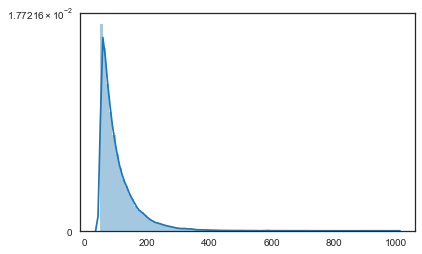

In [9]:
dist = np.array([])
for chid, loc in allow_f_location.items():
    aloc = np.where(loc)
    cdist = np.diff(aloc)
    dist = np.concatenate([dist, cdist[(cdist < 1000) & (cdist > 50)]])

sns.distplot(dist, bins=np.arange(50, 1000, 10))
plt.yscale('symlog')

In [65]:
# Deletion primers
colnames = ['Gene', 
            'W_HomoPrimer', 'W_HomoPrimer_Overhang', 'W_HomoPrimer_Tm',
            'W_HomoPrimer_GC', 'W_HomoPrimer_Loc', 'W_HomoPrimer_Len',
            'W_DelPrimer', 'W_DelPrimer_Tm','W_DelPrimer_GC', 'W_DelPrimer_Loc', 'W_DelPrimer_Len',
            'W_ValPrimer', 'W_ValPrimer_Tm','W_ValPrimer_GC', 'W_ValPrimer_Loc', 'W_ValPrimer_Len',   
            'C_HomoPrimer', 'C_HomoPrimer_Overhang', 'C_HomoPrimer_Tm',
            'C_HomoPrimer_GC', 'C_HomoPrimer_Loc', 'C_HomoPrimer_Len',
            'C_DelPrimer', 'C_DelPrimer_Tm','C_DelPrimer_GC', 'C_DelPrimer_Loc', 'C_DelPrimer_Len',
            'C_ValPrimer', 'C_ValPrimer_Tm','C_ValPrimer_GC', 'C_ValPrimer_Loc', 'C_ValPrimer_Len',
            'F_GenePrimer', 'F_GenePrimer_Tm','F_GenePrimer_GC', 'F_GenePrimer_Loc', 'F_GenePrimer_Len',
            'R_GenePrimer', 'R_GenePrimer_Tm','R_GenePrimer_GC', 'R_GenePrimer_Loc', 'R_GenePrimer_Len',            
            'Direction', 'Chrom', 'Start', 'End'
            ]
deletion_primers = pd.DataFrame(columns=colnames)

In [66]:
gene_columns = {'Gene': [], 'Direction': [], 'Chrom': [], 'Start': [], 'End': []}
for g, loc in bg2_gene.items():
    gene_columns['Gene'].append(g)
    gene_columns['Chrom'].append(loc[0])
    gene_columns['Start'].append(loc[1])
    gene_columns['End'].append(loc[2])
    gene_columns['Direction'].append(loc[3])
deletion_primers = deletion_primers.append(pd.DataFrame(gene_columns), ignore_index=True)
deletion_primers[['Gene', 'Chrom', 'Start', 'End', "Direction"]].head(5)


,Gene,Chrom,Start,End,Direction
0,CAGL0A00099g,ChrA,3286,16984,-
1,CAGL0A00143g,ChrA,26432,28541,-
2,CAGL0A00165g,ChrA,32664,33504,-
3,CAGL0A00187g,ChrA,34114,36385,-
4,CAGL0A00209g,ChrA,36887,39068,+


Design the homology primers that start at the terminal of the gene

In [34]:
def calc_gc(seq: str):
    if not seq:
        return 0
    s = seq.upper()
    return (s.count('C') + s.count('G')) / len(s)


In [95]:
# Determine whether the primer satisfies the standard
# All homoprimers are checked
# best primer:
# 0.2 < gc_ratio < 0.7
# 50 <= tm <= 60
# tm most adjacent to 55
# return primer, tm, gc
def search_good_homo_primer(primers):
    p_attr = [(p, calc_tm(p), calc_gc(p)) for p in primers]
    p_attr.sort(key=lambda x: ((x[2] - 0.2) * (0.7 - x[2]), -abs(x[1] - TM)), 
                reverse=True)
    # No primer satisfies GC limit
    if p_attr[0][2] < 0.:
        # best primer regardless of Tm limit
        return sorted(p_attr, key=lambda x: abs(x[1] - TM))[0]
    else:
        p_attr = [p for p in p_attr if p[2] > 0]
        return sorted(p_attr, key=lambda x: abs(x[1] - TM))[0]


In [139]:
for g, loc in bg2_gene.items():
    chrom, start, end, direction = loc
    seq = bg2_genome[chrom]
    # Search W strand homoprimer
    homoprimers = [rc_seq(seq[start - l: start])
                   for l in range(min_primer_len, max_primer_len + 1)]
    primer, tm, gc = search_good_homo_primer(homoprimers)
    primer = primer.upper()
    overhang = left_overhang if direction == '+' else right_overhang
    deletion_primers.loc[deletion_primers.Gene == g,[
        'W_HomoPrimer', 'W_HomoPrimer_Overhang', 'W_HomoPrimer_Tm',
        'W_HomoPrimer_GC', 'W_HomoPrimer_Loc', 'W_HomoPrimer_Len'
    ]] = (
        primer, overhang + primer, tm, gc, start, len(primer)
    )
    # Search C strand homoprimer
    homoprimers = [seq[end: end + l]
                   for l in range(min_primer_len, max_primer_len + 1)
                  ]
    primer, tm, gc = search_good_homo_primer(homoprimers)
    primer = primer.upper()
    overhang = left_overhang if direction == '-' else right_overhang
    deletion_primers.loc[deletion_primers.Gene == g,[
        'C_HomoPrimer', 'C_HomoPrimer_Overhang', 'C_HomoPrimer_Tm',
        'C_HomoPrimer_GC', 'C_HomoPrimer_Loc', 'C_HomoPrimer_Len'
    ]] = (
        primer, overhang + primer, tm, gc, end, len(primer)
    )


/home/zhuwei/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


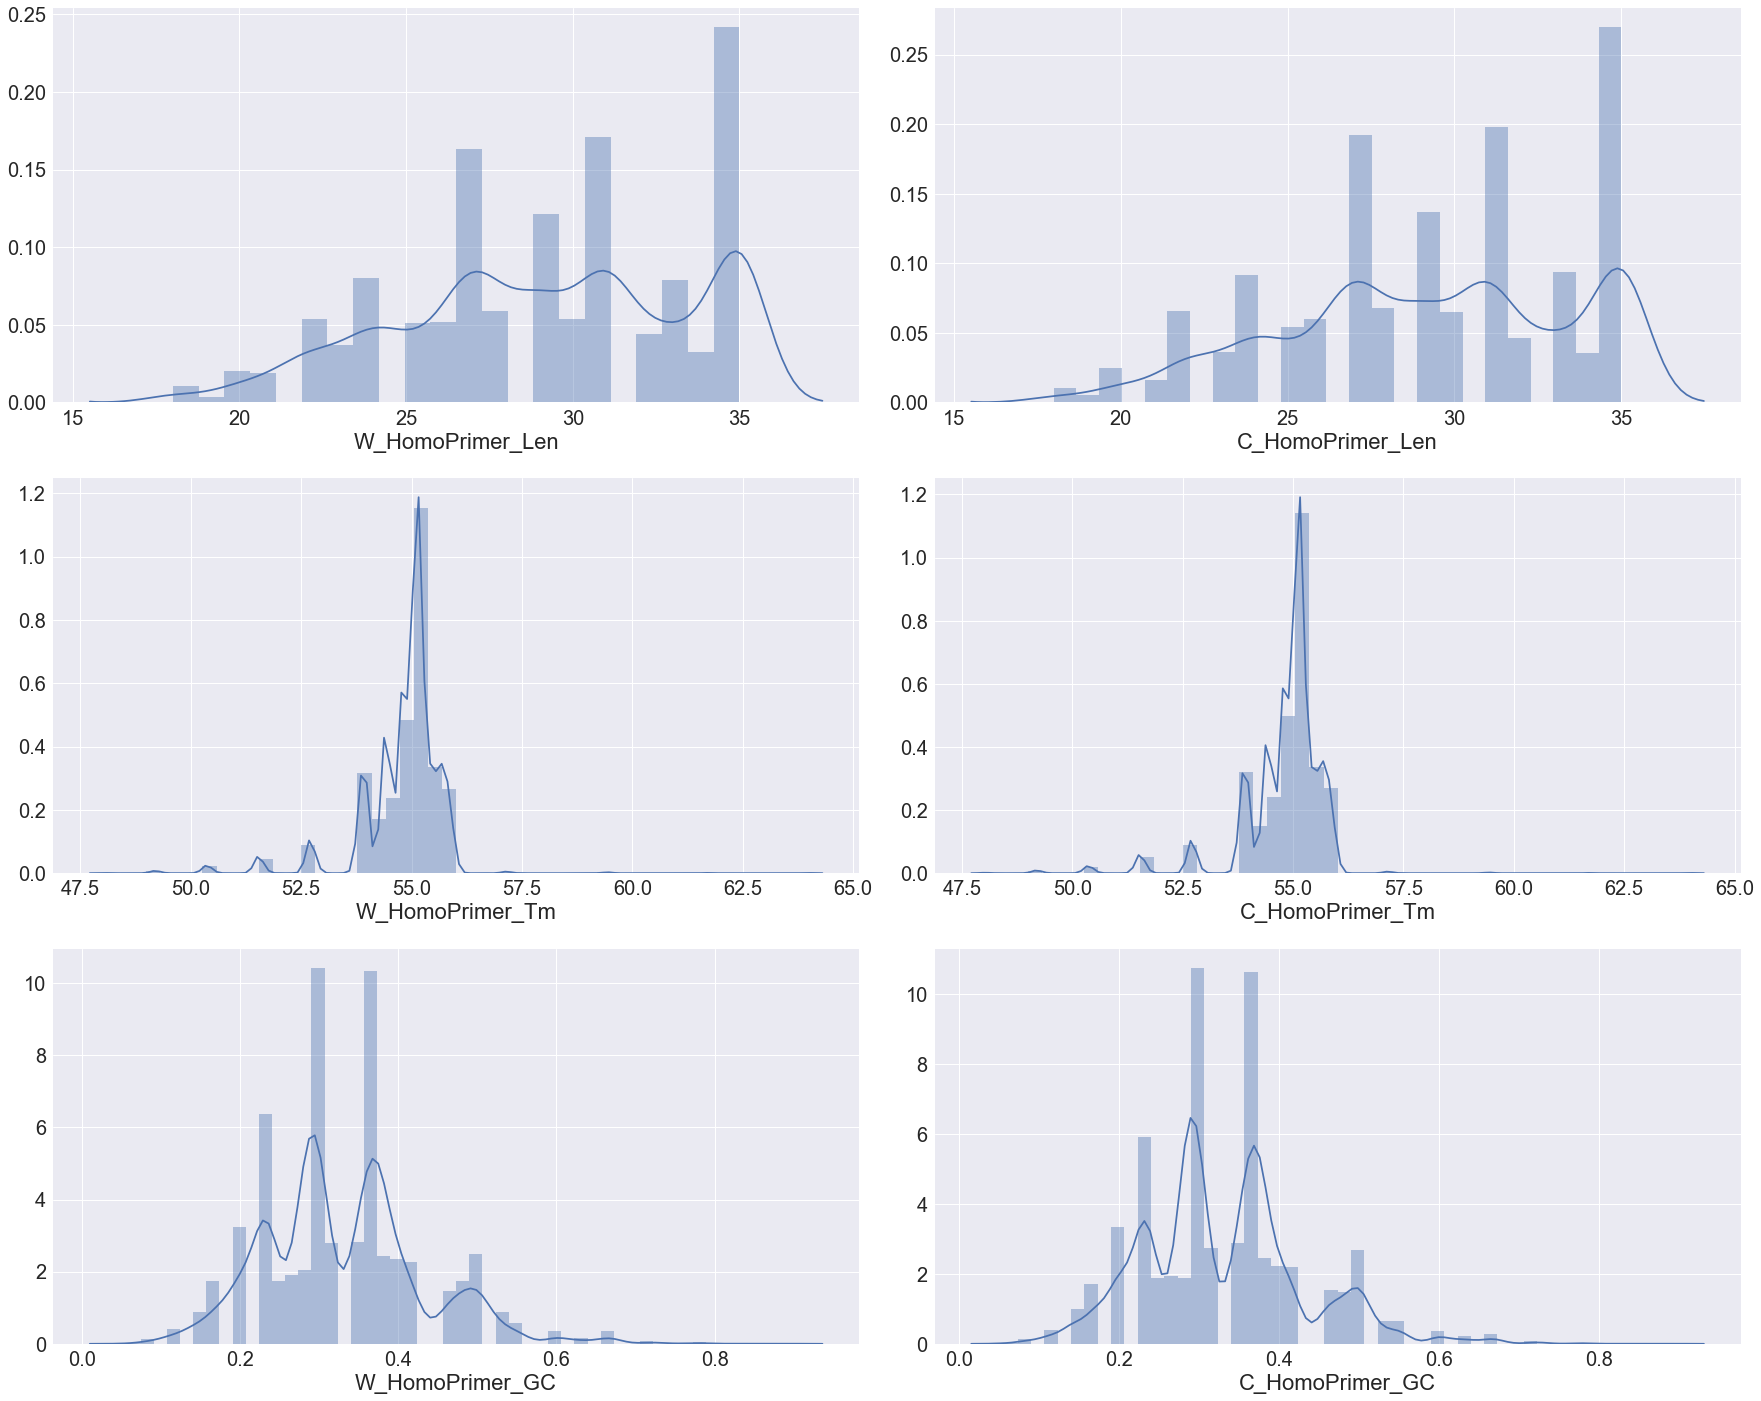

In [149]:
ax = plt.subplot(321)
sns.distplot(deletion_primers.W_HomoPrimer_Len.dropna().astype('int32'))
ax = plt.subplot(323)
sns.distplot(deletion_primers.W_HomoPrimer_Tm.dropna().astype('float'))
ax = plt.subplot(325)
sns.distplot(deletion_primers.W_HomoPrimer_GC.dropna().astype('float'))
ax = plt.subplot(322)
sns.distplot(deletion_primers.C_HomoPrimer_Len.dropna().astype('int32'))
ax = plt.subplot(324)
sns.distplot(deletion_primers.C_HomoPrimer_Tm.dropna().astype('float'))
ax = plt.subplot(326)
sns.distplot(deletion_primers.C_HomoPrimer_GC.dropna().astype('float'))
plt.tight_layout()
plt.savefig('bg2.05.02.homo.primer.stat.png')


In [119]:
# Search for good flanking / validate primer
# All primers are checked
# best primer:
# 0.2 < gc_ratio < 0.7
# 50 <= tm <= 60
# tm most adjacent to 55
# return primer, tm, gc, loc
def search_good_del_val_primer(primers, target_tm):
    p_attr = [(p[0], calc_tm(p[0]), calc_gc(p[0]), p[1]) for p in primers]
    p_attr.sort(key=lambda x: ((x[2] - 0.2) * (0.7 - x[2]), -abs(x[1] - target_tm)), 
                reverse=True)
    # No primer satisfies GC limit
    if p_attr[0][2] < 0.:
        # best primer regardless of Tm limit
        return sorted(p_attr, key=lambda x: abs(x[1] - target_tm))[0]
    else:
        gc_p_attr = [p for p in p_attr if p[2] > 0]
        best_gc_primer = sorted(gc_p_attr, key=lambda x: abs(x[1] - target_tm))[0]
        if abs(best_gc_primer[1] - target_tm) > tm_tolerance:
            return sorted(p_attr, key=lambda x: abs(x[1] - target_tm))[0]
        else:
            return best_gc_primer

In [130]:
# Search Deletion Flanking primers
no_w_unique_del_gene = []
no_c_unique_del_gene = []
no_w_tm_del_gene = []
no_c_tm_del_gene = []
for g, loc in bg2_gene.items():
    chrom, start, end, direction = loc
    chid = ord(chrom[-1]) - 65
    seq = bg2_genome[chrom]
    # Search W strand flank primer
    homotm = deletion_primers[deletion_primers.Gene == g].W_HomoPrimer_Tm \
        .astype('float').values[0]
    primer_candidates = []
    for p in range(start - max_pcr, start - min_pcr):
        if not allow_f_location[chid][p]:
            continue
        # Extend the primer at 5'
        p_end = p + ksize
        primer_candidates.extend([(seq[p_end - l: p_end], p_end)
                                 for l in range(min_reg_primer_len,
                                               max_reg_primer_len + 1)])
    if len(primer_candidates) == 0:
        no_w_unique_del_gene.append(g)
        primer_candidates.extend([
            (seq[p - l: p], p)
            for p in range(start - max_pcr, start - min_pcr)
            for l in range(min_reg_primer_len, max_reg_primer_len + 1)
        ])
    primer, tm, gc, loc = search_good_del_val_primer(primer_candidates,
                                                    target_tm = homotm)
    if abs(tm - homotm) > tm_tolerance:
        if g == no_w_unique_del_gene[-1]:
            no_w_tm_del_gene.append(g)
        else:
            primer_candidates = [
                (seq[p - l: p], p)
                for p in range(start - max_pcr, start - min_pcr)
                for l in range(min_reg_primer_len, max_reg_primer_len + 1)
            ]
            
        primer, tm, gc, loc = search_good_del_val_primer(primer_candidates,
                                                        target_tm = homotm)
        if abs(tm - homotm) > tm_tolerance:
            no_w_tm_del_gene.append(g)
    loc -= (len(primer) - 1)
        

    deletion_primers.loc[deletion_primers.Gene == g,[
            'W_DelPrimer', 'W_DelPrimer_Tm','W_DelPrimer_GC', 
            'W_DelPrimer_Loc', 'W_DelPrimer_Len',
    ]] = (
        primer, tm, gc, loc, len(primer)
    )
    
    # Search C strand homoprimer
    homotm = deletion_primers[deletion_primers.Gene == g] \
        .C_HomoPrimer_Tm.astype('float').values[0]
    primer_candidates = []
    for p in range(end + min_pcr, end + max_pcr):
        if not allow_f_location[chid][p]:
            continue
        # Extend the primer at 5'
        p_end = p
        primer_candidates.extend([(rc_seq(seq[p_end: p_end + l]), p_end)
                                 for l in range(min_reg_primer_len,
                                               max_reg_primer_len + 1)])
    if len(primer_candidates) == 0:
        no_c_unique_del_gene.append(g)
        primer_candidates.extend([
            (rc_seq(seq[p: p + l]), p)
            for p in range(end + min_pcr, end + max_pcr)
            for l in range(min_reg_primer_len, max_reg_primer_len + 1)
        ])        

    primer, tm, gc, loc = search_good_del_val_primer(primer_candidates,
                                                    target_tm = homotm)
    if abs(tm - homotm) > tm_tolerance:
        if g == no_c_unique_del_gene[-1]:
            no_c_tm_del_gene.append(g)
        else:
            primer_candidates = [
                (rc_seq(seq[p: p + l]), p)
                for p in range(end + min_pcr, end + max_pcr)
                for l in range(min_reg_primer_len, max_reg_primer_len + 1)
            ]
            
        primer, tm, gc, loc = search_good_del_val_primer(primer_candidates,
                                                        target_tm = homotm)
        if abs(tm - homotm) > tm_tolerance:
            no_c_tm_del_gene.append(g)
            
    loc += len(primer)

    deletion_primers.loc[deletion_primers.Gene == g,[
            'C_DelPrimer', 'C_DelPrimer_Tm','C_DelPrimer_GC', 
            'C_DelPrimer_Loc', 'C_DelPrimer_Len',
    ]] = (
        primer, tm, gc, loc, len(primer)
    )

/home/zhuwei/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


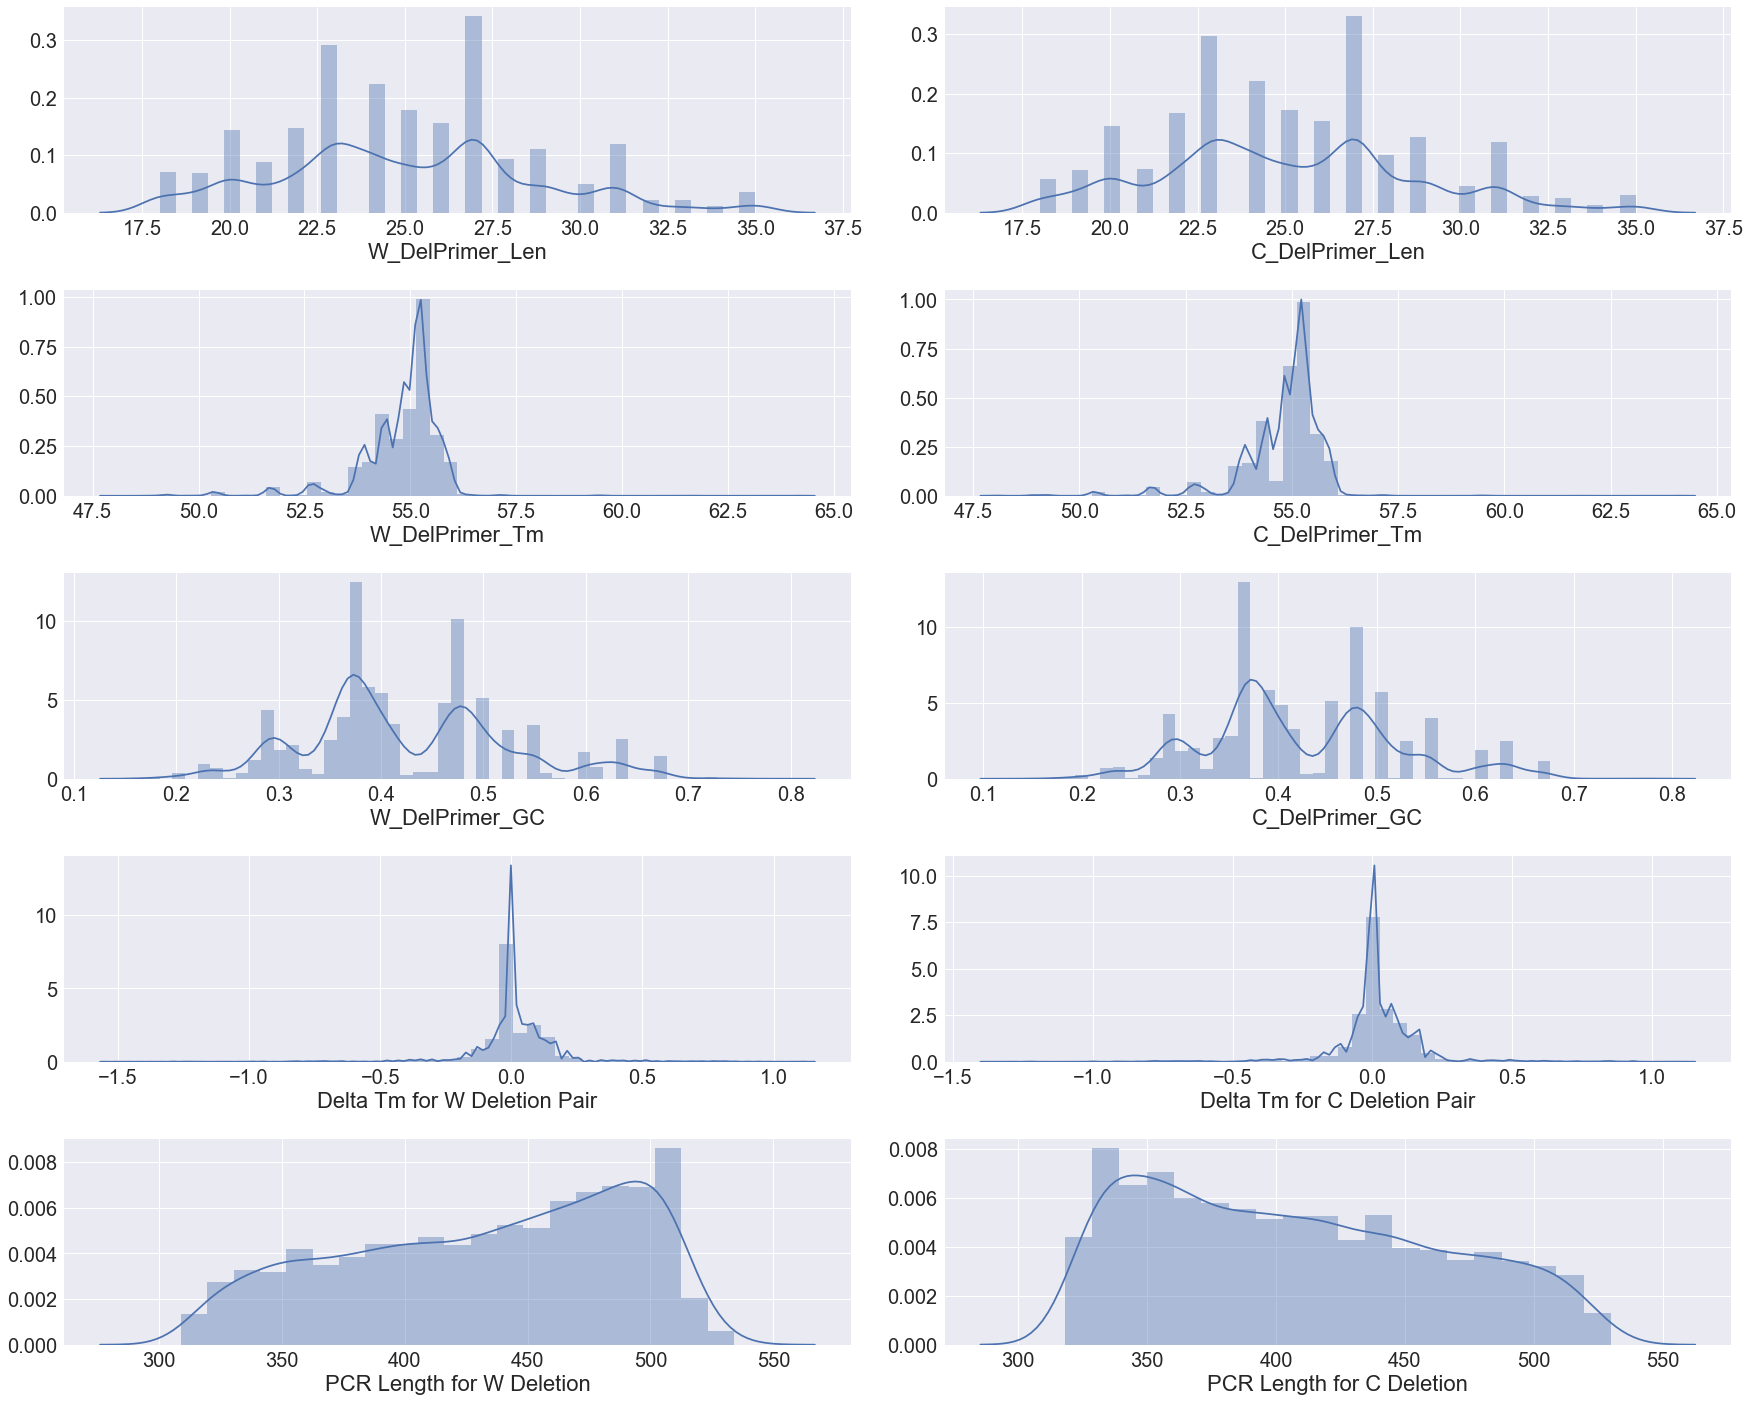

In [148]:
delta_del_w_tm = deletion_primers.W_DelPrimer_Tm - deletion_primers.W_HomoPrimer_Tm
delta_del_w_tm.rename('Delta Tm for W Deletion Pair', inplace=True)
delta_del_c_tm = deletion_primers.C_DelPrimer_Tm - deletion_primers.C_HomoPrimer_Tm
delta_del_c_tm.rename('Delta Tm for C Deletion Pair', inplace=True)
w_product_len = deletion_primers.W_HomoPrimer_Loc - deletion_primers.W_DelPrimer_Loc
w_product_len.rename('PCR Length for W Deletion', inplace=True)
c_product_len = deletion_primers.C_DelPrimer_Loc - deletion_primers.C_HomoPrimer_Loc
c_product_len.rename('PCR Length for C Deletion', inplace=True)

ax = plt.subplot(521)
sns.distplot(deletion_primers.W_DelPrimer_Len.dropna().astype('int32'))
ax = plt.subplot(523)
sns.distplot(deletion_primers.W_DelPrimer_Tm.dropna().astype('float'))
ax = plt.subplot(525)
sns.distplot(deletion_primers.W_DelPrimer_GC.dropna().astype('float'))
ax = plt.subplot(522)
sns.distplot(deletion_primers.C_DelPrimer_Len.dropna().astype('int32'))
ax = plt.subplot(524)
sns.distplot(deletion_primers.C_DelPrimer_Tm.dropna().astype('float'))
ax = plt.subplot(526)
sns.distplot(deletion_primers.C_DelPrimer_GC.dropna().astype('float'))
ax = plt.subplot(527)
sns.distplot(delta_del_w_tm.astype('float'))
ax = plt.subplot(528)
sns.distplot(delta_del_c_tm.astype('float'))
ax = plt.subplot(529)
sns.distplot(w_product_len.astype('int32'))
ax = plt.subplot(5,2,10)
sns.distplot(c_product_len.astype('int32'))
plt.tight_layout()
plt.savefig('bg2.05.02.del.primer.stat.png')

In [137]:
# Calc tm for NA primer to search for validate primer
na_r_primer = 'ATGACCAGCACCTCTTTCTC'
na_r_primer2 = 'CCGCTGCTAGGCGCGCCGTG'
na_f_primer = 'GAGTTACTGCTACTGGTGATG'
na_f_primer2 = 'ctacgagaccgacaccgtcgggccgctgacgaagt'
print('''
Tm 5' F_primer: {}
Tm 5' R_primer: {}
Tm 3' F_primer: {}
Tm 3' R_primer: {}
'''.format(
    calc_tm(na_r_primer2), 
    calc_tm(na_r_primer),
    calc_tm(na_f_primer),
    calc_tm(na_f_primer2)))


Tm 5' F_primer: 64.08000000000001
Tm 5' R_primer: 51.78000000000001
Tm 3' F_primer: 52.40476190476191
Tm 3' R_primer: 72.63142857142859



## We should re-design internal primers for NA!
currently using Tm = 55 for validate primers

In [144]:
# Generate validation primer pairs

no_w_unique_val_gene = []
no_c_unique_val_gene = []
no_w_tm_val_gene = []
no_c_tm_val_gene = []

for g, loc in bg2_gene.items():
    chrom, start, end, direction = loc
    chid = ord(chrom[-1]) - 65
    seq = bg2_genome[chrom]
    # Search W strand validate primer
    primer_loc = deletion_primers[deletion_primers.Gene == g] \
        .W_DelPrimer_Loc.astype('int32').values[0]

    primer_candidates = []
    for p in range(start - max_pcr - max_outside, primer_loc -min_outside):
        if not allow_f_location[chid][p]:
            continue
        # Extend the primer at 5'
        p_end = p + ksize
        primer_candidates.extend([(seq[p_end - l: p_end], p_end)
                                 for l in range(min_reg_primer_len,
                                               max_reg_primer_len + 1)])
    if len(primer_candidates) == 0:
        no_w_unique_val_gene.append(g)
        primer_candidates.extend([
            (seq[p - l: p], p)
            for p in range(start - max_pcr - max_outside, primer_loc -min_outside)
            for l in range(min_reg_primer_len, max_reg_primer_len + 1)
        ])
    primer, tm, gc, loc = search_good_del_val_primer(primer_candidates,
                                                    target_tm = TM)
    if abs(tm - TM) > tm_tolerance:
        if g == no_w_unique_val_gene[-1]:
            no_w_tm_val_gene.append(g)
        else:
            primer_candidates = [
                (seq[p - l: p], p)
                for p in range(start - max_pcr - max_outside, primer_loc -min_outside)
                for l in range(min_reg_primer_len, max_reg_primer_len + 1)
            ]
            
        primer, tm, gc, loc = search_good_del_val_primer(primer_candidates,
                                                        target_tm = TM)
        if abs(tm - TM) > tm_tolerance:
            no_w_tm_val_gene.append(g)
    loc -= (len(primer) - 1)
        

    deletion_primers.loc[deletion_primers.Gene == g,[
            'W_ValPrimer', 'W_ValPrimer_Tm','W_ValPrimer_GC', 
            'W_ValPrimer_Loc', 'W_ValPrimer_Len',
    ]] = (
        primer, tm, gc, loc, len(primer)
    )
    
    # Search C strand homoprimer
    primer_loc = deletion_primers[deletion_primers.Gene == g] \
        .C_DelPrimer_Loc.astype('int32').values[0]
    primer_candidates = []
    for p in range(primer_loc + min_outside, end + max_pcr + max_outside):
        if not allow_f_location[chid][p]:
            continue
        # Extend the primer at 5'
        p_end = p
        primer_candidates.extend([(rc_seq(seq[p_end: p_end + l]), p_end)
                                 for l in range(min_reg_primer_len,
                                               max_reg_primer_len + 1)])
    if len(primer_candidates) == 0:
        no_c_unique_val_gene.append(g)
        primer_candidates.extend([
            (rc_seq(seq[p: p + l]), p)
            for p in range(primer_loc + min_outside, end + max_pcr + max_outside)
            for l in range(min_reg_primer_len, max_reg_primer_len + 1)
        ])        

    primer, tm, gc, loc = search_good_del_val_primer(primer_candidates,
                                                    target_tm = TM)
    if abs(tm - TM) > tm_tolerance:
        if g == no_c_unique_val_gene[-1]:
            no_c_tm_val_gene.append(g)
        else:
            primer_candidates = [
                (rc_seq(seq[p: p + l]), p)
                for p in range(primer_loc + min_outside, end + max_pcr + max_outside)
                for l in range(min_reg_primer_len, max_reg_primer_len + 1)
            ]
            
        primer, tm, gc, loc = search_good_del_val_primer(primer_candidates,
                                                        target_tm = TM)
        if abs(tm -TM) > tm_tolerance:
            no_c_tm_val_gene.append(g)
            
    loc += len(primer)

    deletion_primers.loc[deletion_primers.Gene == g,[
            'C_ValPrimer', 'C_ValPrimer_Tm','C_ValPrimer_GC', 
            'C_ValPrimer_Loc', 'C_ValPrimer_Len',
    ]] = (
        primer, tm, gc, loc, len(primer)
    )

/home/zhuwei/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


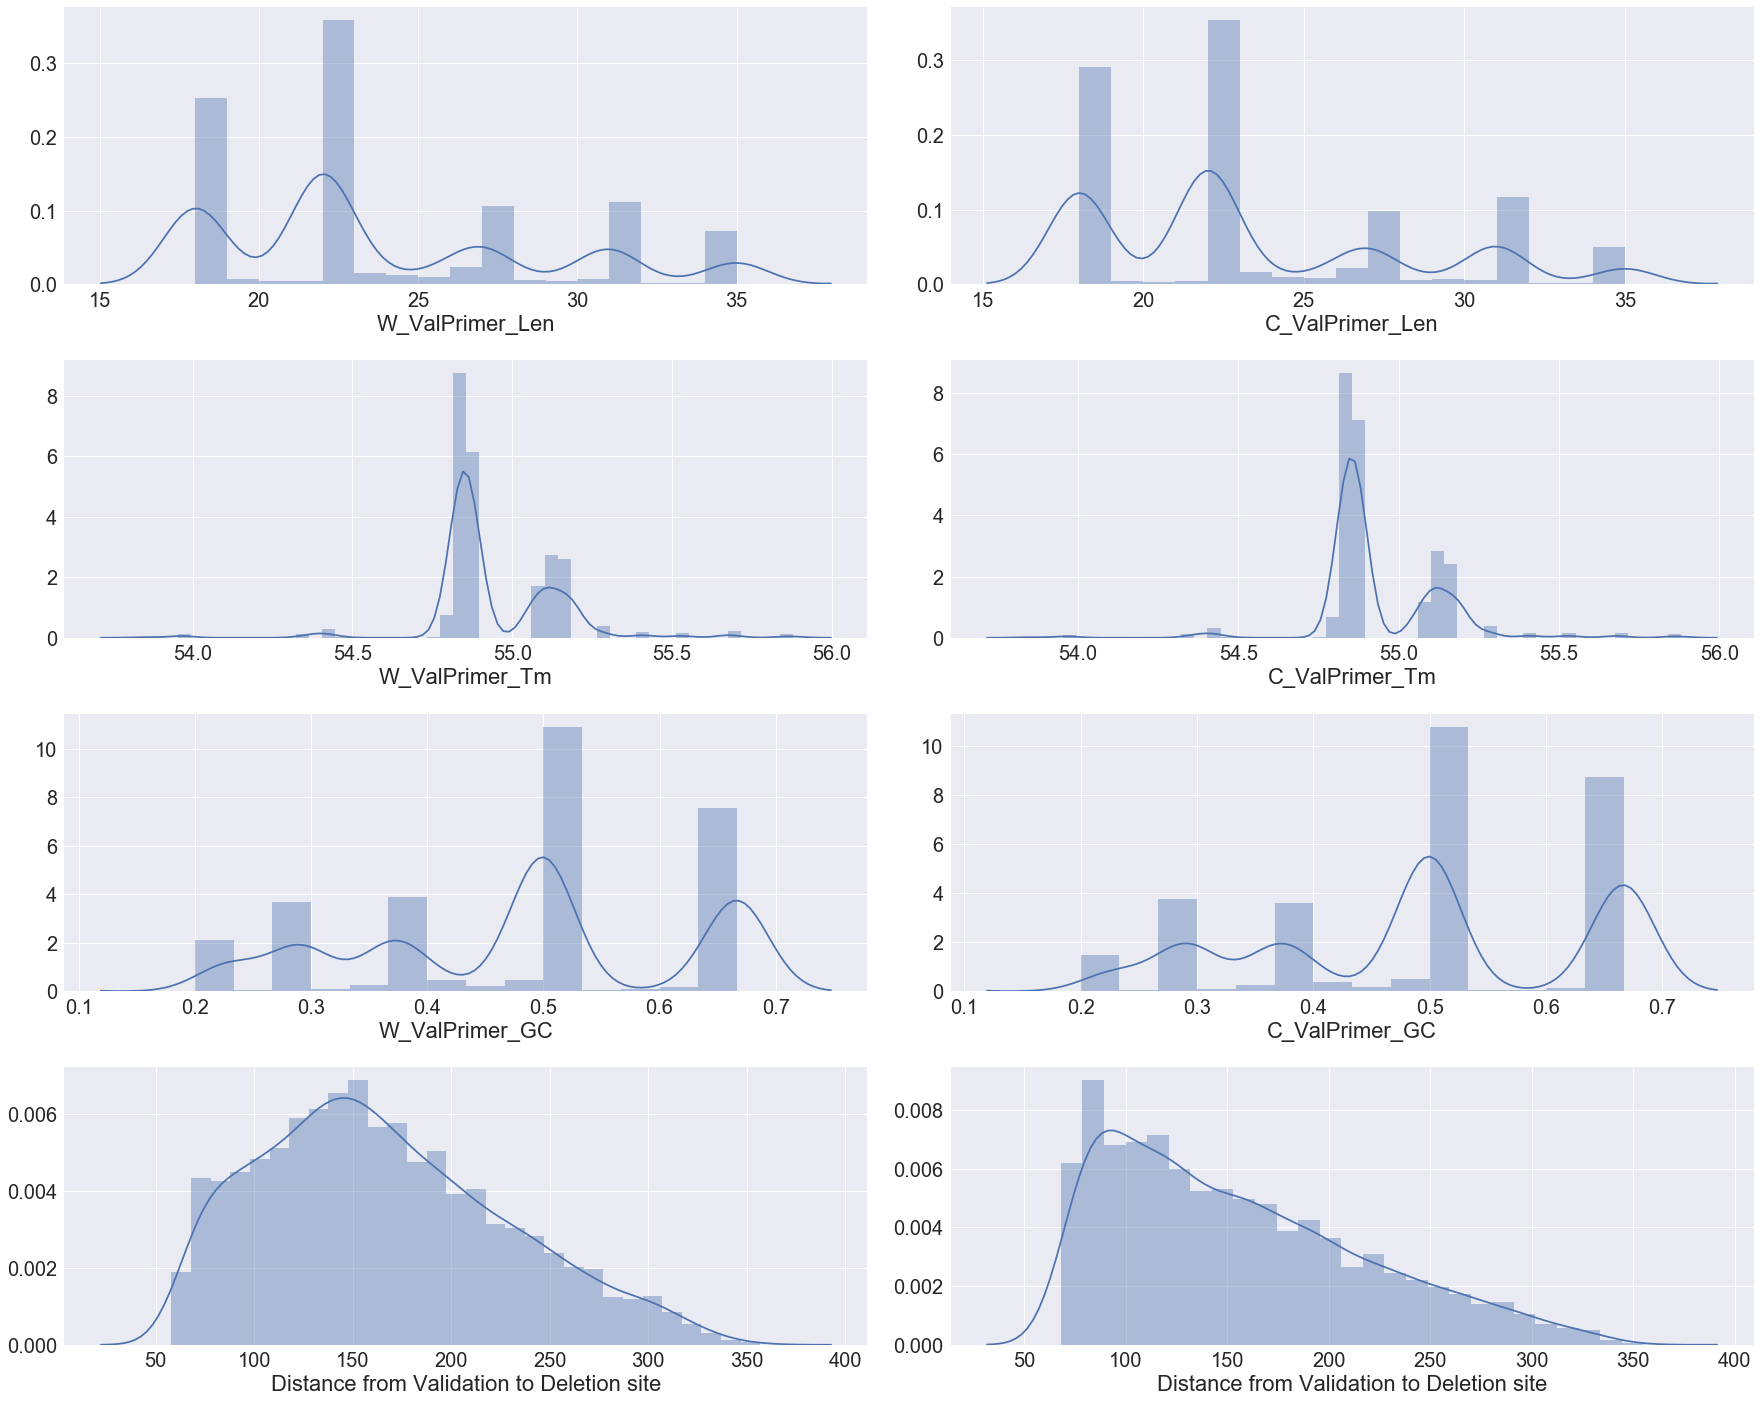

In [147]:

w_val_product_len = deletion_primers.W_DelPrimer_Loc - deletion_primers.W_ValPrimer_Loc
w_val_product_len.rename('Distance from Validation to Deletion site', inplace=True)
c_val_product_len = deletion_primers.C_ValPrimer_Loc - deletion_primers.C_DelPrimer_Loc
c_val_product_len.rename('Distance from Validation to Deletion site', inplace=True)

ax = plt.subplot(421)
sns.distplot(deletion_primers.W_ValPrimer_Len.dropna().astype('int32'))
ax = plt.subplot(423)
sns.distplot(deletion_primers.W_ValPrimer_Tm.dropna().astype('float'))
ax = plt.subplot(425)
sns.distplot(deletion_primers.W_ValPrimer_GC.dropna().astype('float'))
ax = plt.subplot(422)
sns.distplot(deletion_primers.C_ValPrimer_Len.dropna().astype('int32'))
ax = plt.subplot(424)
sns.distplot(deletion_primers.C_ValPrimer_Tm.dropna().astype('float'))
ax = plt.subplot(426)
sns.distplot(deletion_primers.C_ValPrimer_GC.dropna().astype('float'))
ax = plt.subplot(427)
sns.distplot(w_val_product_len.astype('int32'))
ax = plt.subplot(428)
sns.distplot(c_val_product_len.astype('int32'))
plt.tight_layout()
plt.savefig('bg2.05.02.val.primer.stat.png')

In [156]:
deletion_primers = deletion_primers[colnames]
deletion_primers.to_csv('bg2.05.02.deletion.primer.csv')

In [98]:
test
testtest[test.A==1].B = NA

,A,B,C
0,1,4,7
1,2,12,12
2,3,6,9


In [109]:
type(test[test.A==1].B.values[0])

numpy.int64

In [155]:
delet

['Gene',
 'W_HomoPrimer',
 'W_HomoPrimer_Overhang',
 'W_HomoPrimer_Tm',
 'W_HomoPrimer_GC',
 'W_HomoPrimer_Loc',
 'W_HomoPrimer_Len',
 'W_DelPrimer',
 'W_DelPrimer_Tm',
 'W_DelPrimer_GC',
 'W_DelPrimer_Loc',
 'W_DelPrimer_Len',
 'W_ValPrimer',
 'W_ValPrimer_Tm',
 'W_ValPrimer_GC',
 'W_ValPrimer_Loc',
 'W_ValPrimer_Len',
 'C_HomoPrimer',
 'C_HomoPrimer_Overhang',
 'C_HomoPrimer_Tm',
 'C_HomoPrimer_GC',
 'C_HomoPrimer_Loc',
 'C_HomoPrimer_Len',
 'C_DelPrimer',
 'C_DelPrimer_Tm',
 'C_DelPrimer_GC',
 'C_DelPrimer_Loc',
 'C_DelPrimer_Len',
 'C_ValPrimer',
 'C_ValPrimer_Tm',
 'C_ValPrimer_GC',
 'C_ValPrimer_Loc',
 'C_ValPrimer_Len',
 'F_GenePrimer',
 'F_GenePrimer_Tm',
 'F_GenePrimer_GC',
 'F_GenePrimer_Loc',
 'F_GenePrimer_Len',
 'R_GenePrimer',
 'R_GenePrimer_Tm',
 'R_GenePrimer_GC',
 'R_GenePrimer_Loc',
 'R_GenePrimer_Len',
 'Direction',
 'Chrom',
 'Start',
 'End']